Chapter 5 - Lab on The Finite Element Method
============================================

# Exercise I

Let $f\in L^{2}(0,1)$.

Consider

$$ (5.1)\quad\left\{
    \begin{array}{ll}
       - \displaystyle u^{\prime\prime}=f \quad \textrm{in}\ ]0,1[,\\
       u(0)=\alpha\quad\textrm{and}\quad u(1)=\beta. 
    \end{array}\right.$$
                                         
with $\alpha,\beta\in\mathbb{R}$.

In this notebook, we will need several librairies:

In [1]:
# Two standard librairies for mathematical functions

import math
import numpy as np


# A standard library for plotting

import matplotlib.pyplot as plt


# Functions for numerical quadrature
# (numerical approxmation of an integral)

from scipy.integrate import quad
from scipy import special

## Question 1

To determine a PDE with homogeneous Dirichlet conditions that is equivalent to (5.1), we use the lifting technique.

It is sufficient to chose $u_{0}$ whose value at 0 is $\alpha$ and whose value at $\beta$ is $1$. For instance, let 
$u_0(x)=\alpha (1-x)+\beta x$ an consider $\tilde{u}=u-u_0$. 
Function $\tilde{u}$ is a solution to

$$\left \{
    \begin{array}{l}
      - \displaystyle \tilde{u}''= g\quad\textrm{in} ]0,1[,\\
      \tilde{u}(0)=0\quad\textrm{and}\quad \tilde{u}(1)=0. 
    \end{array}
   \right. $$

where $g(x) = f(x)+u_{0}''(x)$.

This choice of $u_0$ leads to $u_0''=0$, therefore $g=f$ (subseqently there is no need to define another function).

In [2]:
def u0(x):
    return alpha*(1-x) + beta*x

# We will need to define alpha and beta before using this function.

## Question 2

We want to write the variational formulation.
We follow the steps indicated in the handout example https://cagnol.link/pde4handout

To simplify the notations, in this question we omit the tilde and write $u$ instead of $\tilde{u}$.

We obtain the variational formulation $$a(u,\varphi)=l(\varphi)$$
where $a$ is defined from $C^1_0([0,1])\times C^1_0([0,1])$ to ${\mathbb{R}}$ by
$$a(u,v)=\int_0^1 u'v'$$
and $l$ is defined from $C^1_0([0,1])$ to $\mathbb {R}$ by $$l(v)=\int_0^1 gv$$

## Question 3

Let $J\in\mathbb{N}^*$ and $$h=\frac{1}{J+1}$$ 

In [4]:
J=5       # Number of nodes - ends excluded
h=1/(J+1) # Discretizaton step

Consider a subdivision $(x_j)_{j\in\{0,...,J+1\}}$ of $[0,1]$ where $x_j=jh$.
Let $P_1$ be the set of polynomials of degree lower than 1 and


$$H_{0,h}=  \{v \in C^0([0,1])\ |\ \forall j\in\{0,...,J\},\;v_{|[x_j,x_{j+1}]}\in P_1\ \textrm{and}\ v(0)=v(1)=0\}$$

We note $N_h=\operatorname{dim} H_{0,h}$.
We have $N_h=J$.

Consider the basis $(\phi_1,...,\phi_{N_h})$ of $H_{0,h}$ composed of hat functions

$$\phi_j(x)=\left\{\begin{array}{lll}
    0 & \textrm{if} & x\in[0,(j-1)h[\\
    \frac{1}{h}x-j+1 & \textrm{if} & x\in [(j-1)h,jh]\\
    -\frac{1}{h}x+j+1 & \textrm{if} & x\in ]jh,(j+1)h]\\
    0 & \textrm{if} & x\in](j-1)h,1]
    \end{array}
    \right.$$

In [5]:
# We define the hat functions

def phi(x,j):
    if x<(j-1)*h:
        return 0
    elif x<j*h:
        return 1+(x-j*h)/h
    elif x<(j+1)*h:
        return 1-(x-j*h)/h
    else: # x>(j+1)*h
        return 0

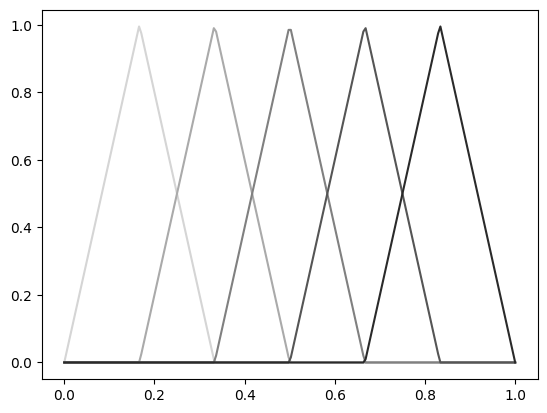

In [6]:
# We plot with several shades of gray

# Number of points to represent the function
Nx = 200 

x = np.arange(Nx,dtype=float)
y = np.arange(Nx,dtype=float)

for j in range(1,J+1): # j is in between 1 and J. See the definition of range() in case of doubt!

    s = 0
    
    for t in np.linspace(0.0,1.0,Nx):
        x[s] = t
        y[s] = phi(t,j)
        s = s+1
    
    color = 1-j/(J+1)
    
    plt.plot(x,y,color=(color,color,color))

plt.show()

# Exercise V (sequel to Exercice I)

## Question 1
$$\forall i\in[1,J],\ a(u_h,\phi_i)=l(\phi_i)$$ 
iff $$\forall i\in[1,J],\ a\left(\sum_{j=1}^Ju_h^j\phi_j,\phi_i\right)=l(\phi_i)$$
iff $$\forall i\in[1,J],\ \sum_{j=1}^Ju_h^ja(\phi_j,\phi_i)=l(\phi_i)$$
iff $$A_hU_h=F_h$$
Let us note
- $A_h$ the $J\times J$ matrix whose coefficients are $a(\phi_j,\phi_i)$ at line $i$ and column $j$
- $U_h\in\mathbb{R}^J$ the vector whose components are $u_h^1,\ldots,u_h^J$
- $F_h\in\mathbb{R}^J$ the vector whose $i$-th component is $l(\phi_i)$

## Question 2
To compute $A_h$, we can: 
- Compute $a(\phi_i,\phi_j)$ by quadrature
- Compute $a(\phi_i,\phi_j)$ algebraically.

Thus, there are two methods.

Here, we shall computer $a(\varphi_i,\varphi_j)$ by quadrature.
In exercise VII, we will compute it algebraically (or use the algebraic computation carried out in the lecture).

In [8]:
# We need the derivative of the hat functions

def phi_prime(x,j):
    if x<(j-1)*h:
        return 0
    elif x<j*h:
        return 1/h
    elif x<(j+1)*h:
        return -1/h
    else: # x>(j+1)*h
        return 0

In [9]:
def phi_prime_phi_prime(x,i,j):
    # Returns phi_i'(x)*phi_j'(x)
    return phi_prime(x,i)*phi_prime(x,j)